In [2]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Study Bergen Nh (Amsterdan) LSTM

In [106]:
import warnings
warnings.filterwarnings("ignore")

In [115]:
from dateutil.parser import parse 
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [121]:
hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
station = 235
data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

# Obtain dataset
df = spark.read.parquet(data_files) \
        .withColumn("precipitation", col("precipitation").cast("float")) \
        .select("date","precipitation") \
        .toPandas()

In [122]:
# Set the date column as the index and ensure it's a DatetimeIndex
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34951 entries, 1927-07-01 to 2023-03-10
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  34951 non-null  float32
dtypes: float32(1)
memory usage: 409.6 KB


In [124]:
def check_missing_values(df):
    # Check for nulls
    print(f"Number of null value in timeseries {df.precipitation.isnull().sum()}")

    # Check there is data all days of the timeseries
    start_date = pd.Timestamp(df.index.min())
    end_date = pd.Timestamp(df.index.max())

    # Create a date range for the entire period
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Check for missing dates
    missing_dates = full_date_range.difference(df.index)

    if not missing_dates.empty:
        print(f"There are {len(missing_dates)} missing dates in the index:")
        print(missing_dates)
    else:
        print("There are no missing dates in the index.")

check_missing_values(df)

Number of null value in timeseries 0
There are 1 missing dates in the index:
DatetimeIndex(['1932-01-01'], dtype='datetime64[ns]', freq=None)


# Fill missing value with precipitation of the closest stations to 

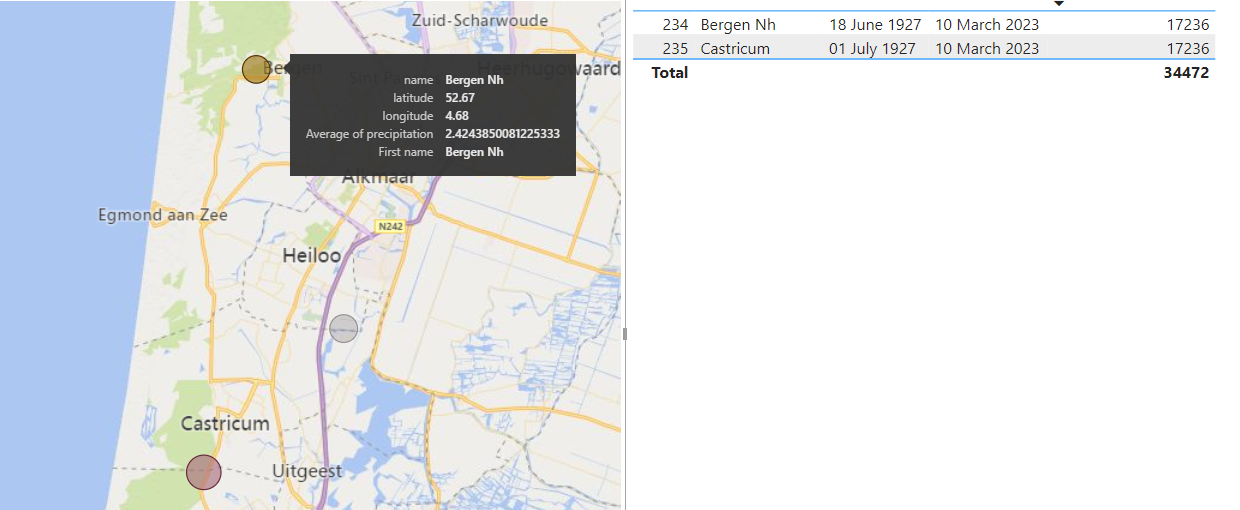

In [125]:
df.at['1932-01-01','precipitation'] = 0.30

In [126]:
check_missing_values(df)

Number of null value in timeseries 0
There are no missing dates in the index.


## Plot series different time scales. Remove outliers


In [101]:
def seasonality_plots(grouped, freq="1D", start = '2015-01-01', end = '2023-01-01', remove_outliers = True):
    df_s = grouped[(grouped.index >= start) & (grouped.index <= end)]

    if(remove_outliers):
        # Calculate the IQR
        Q1 = df_s['precipitation'].quantile(0.25)
        Q3 = df_s['precipitation'].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        # Filter out the outliers
        df_s = df_s[(df_s['precipitation'] >= lower_bound) & (df_s['precipitation'] <= upper_bound)]

    # Prepare data
    df_s['year'] = [d.year for d in df_s.index]
    df_s['month'] = [d.strftime('%b') for d in df_s.index]
    years = df_s['year'].unique()
    
    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y='precipitation', data=df_s, ax=axes[0])
    sns.boxplot(x='month', y='precipitation', data=df_s.loc[~df_s.year.isin([1900, 2023]), :])

    # Set Title
    axes[0].set_title(f'{freq} Year-wise Box Plot\n(The Trend)', fontsize=18); 
    axes[1].set_title(f'{freq} Month-wise Box Plot\n(The Seasonality)', fontsize=18)
    plt.show()
    
    
    x = df_s.index
    y1 = df_s['precipitation'].values

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120, )
    plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
    plt.ylim(-15, 15)
    plt.title(f'Precipitation {freq} (Two Side View)', fontsize=16)
    plt.hlines(y=0, xmin=np.min(df_s.index), xmax=np.max(df_s.index), linewidth=.5)
    plt.show()

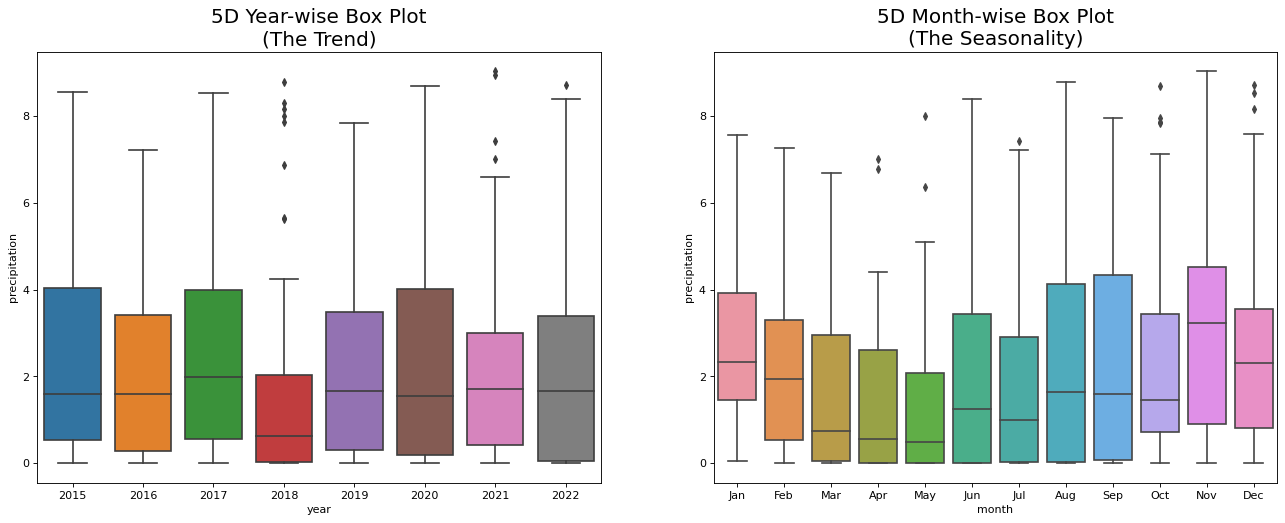

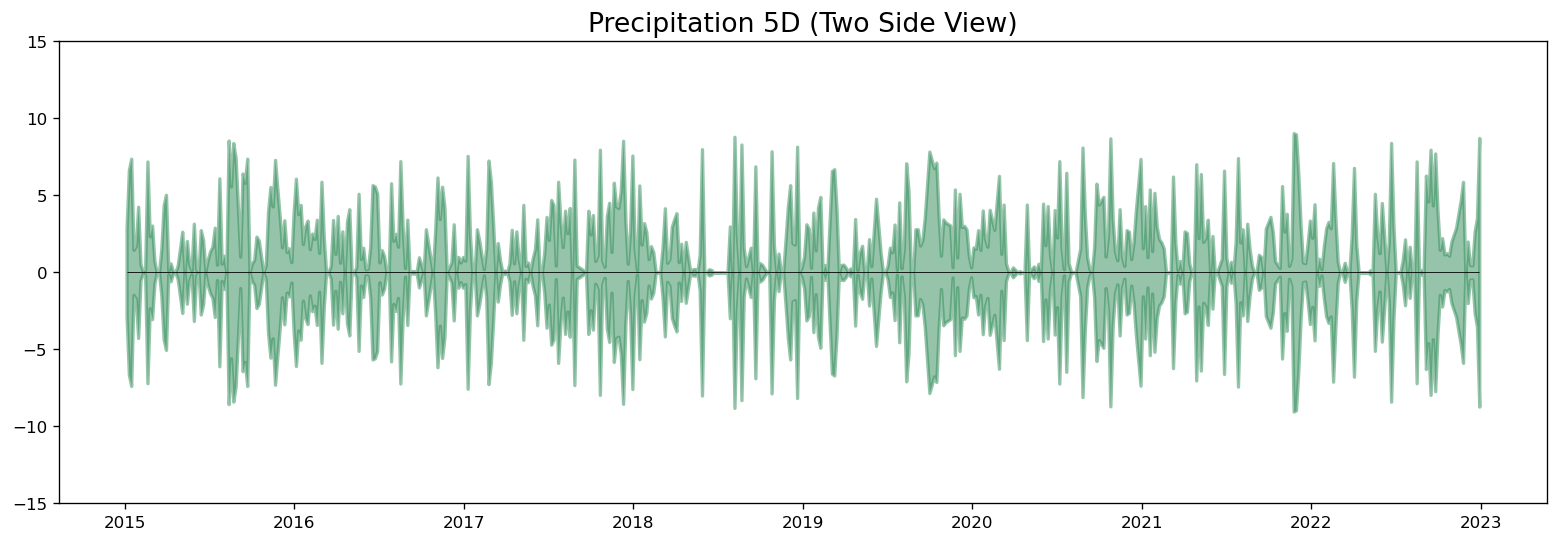

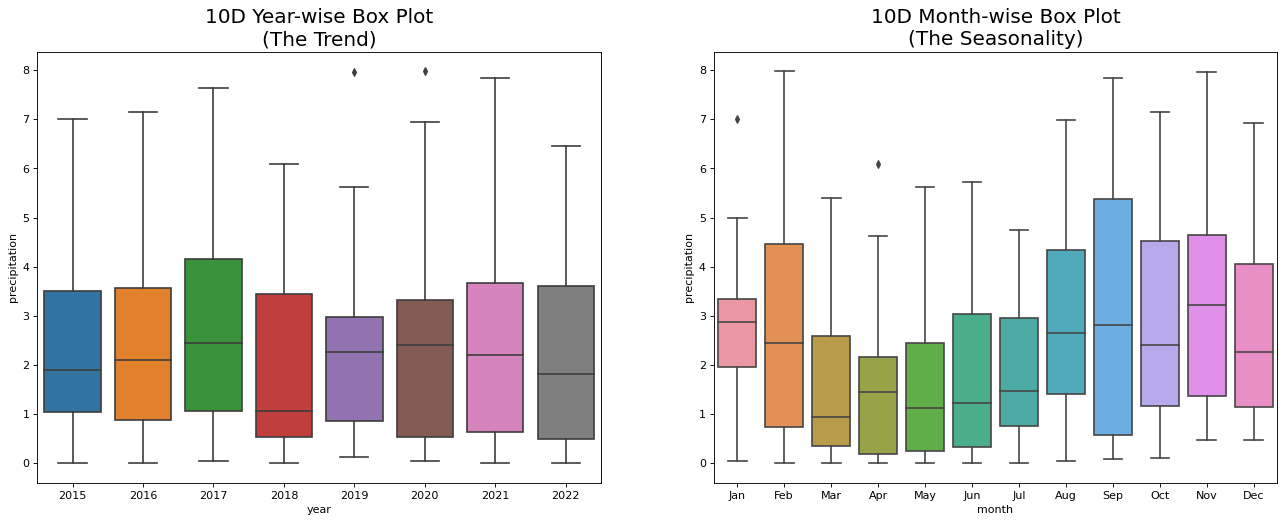

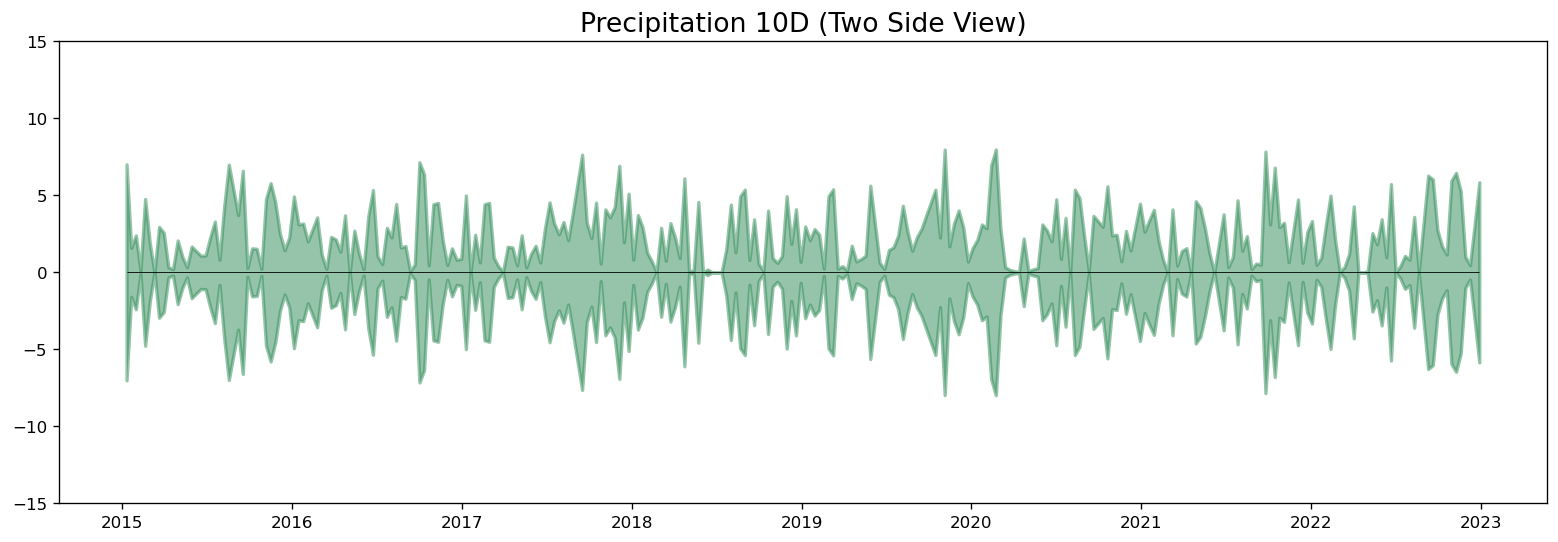

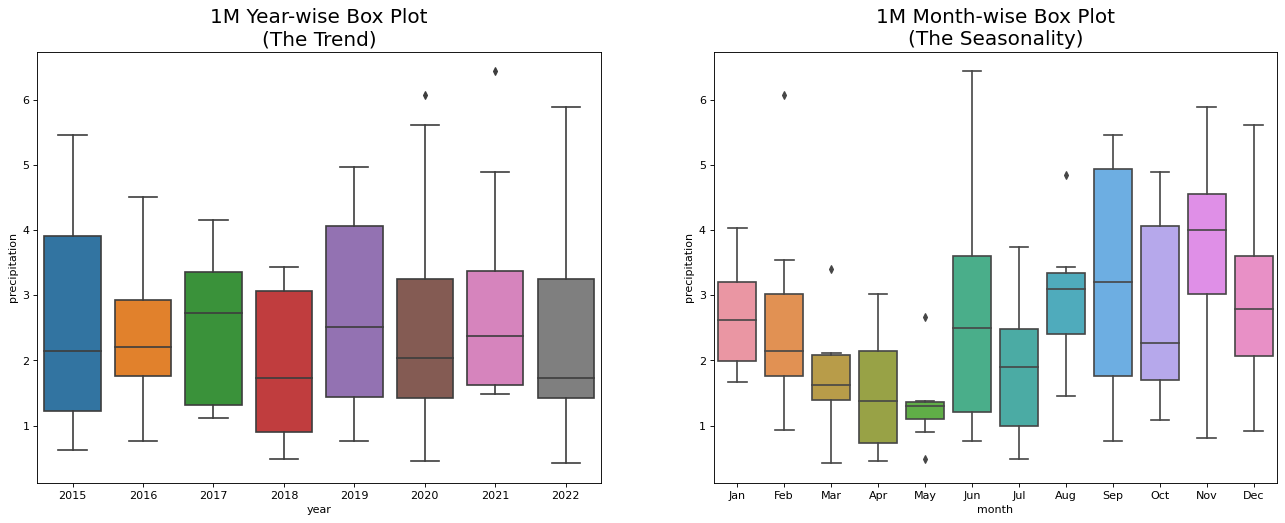

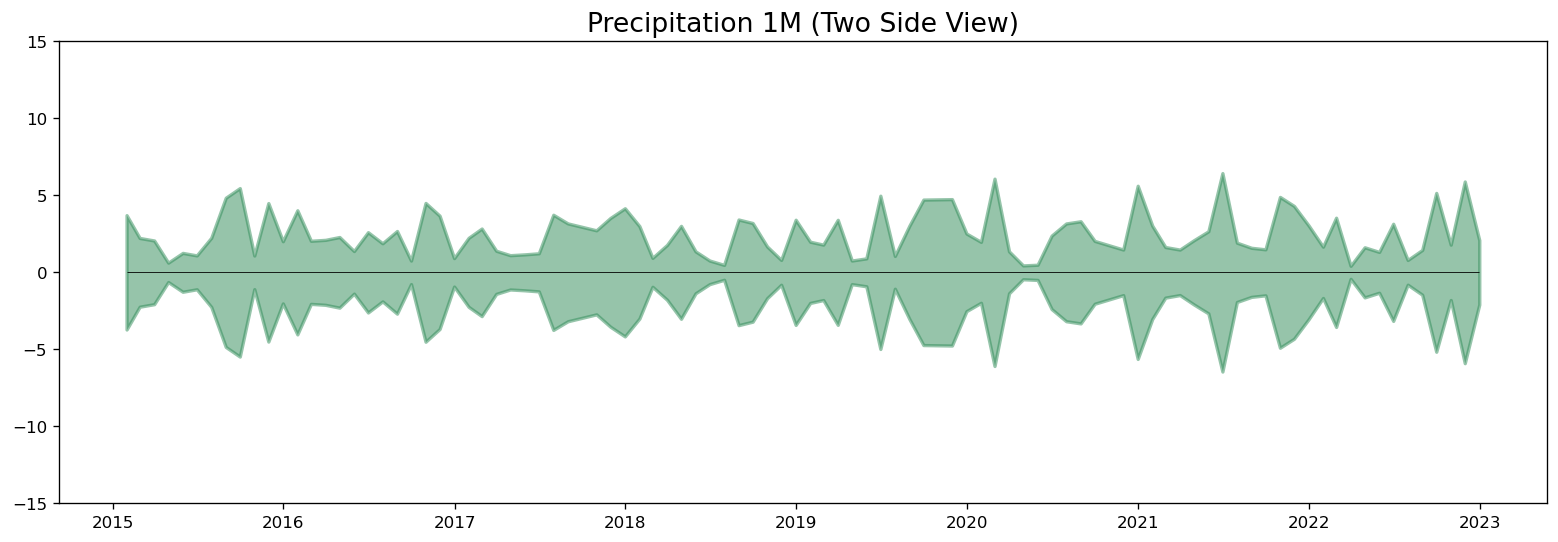

In [128]:
grouped = df.groupby(pd.Grouper(freq='5d')).mean()
seasonality_plots(grouped,freq="5D",remove_outliers=True)

grouped = df.groupby(pd.Grouper(freq='10d')).mean()
seasonality_plots(grouped,freq="10D",remove_outliers=True)

grouped = df.resample('1M').mean()
seasonality_plots(grouped,freq="1M",remove_outliers=True)

# Seasonality Decomposition Monthly

In [129]:
#%pip install statsmodels

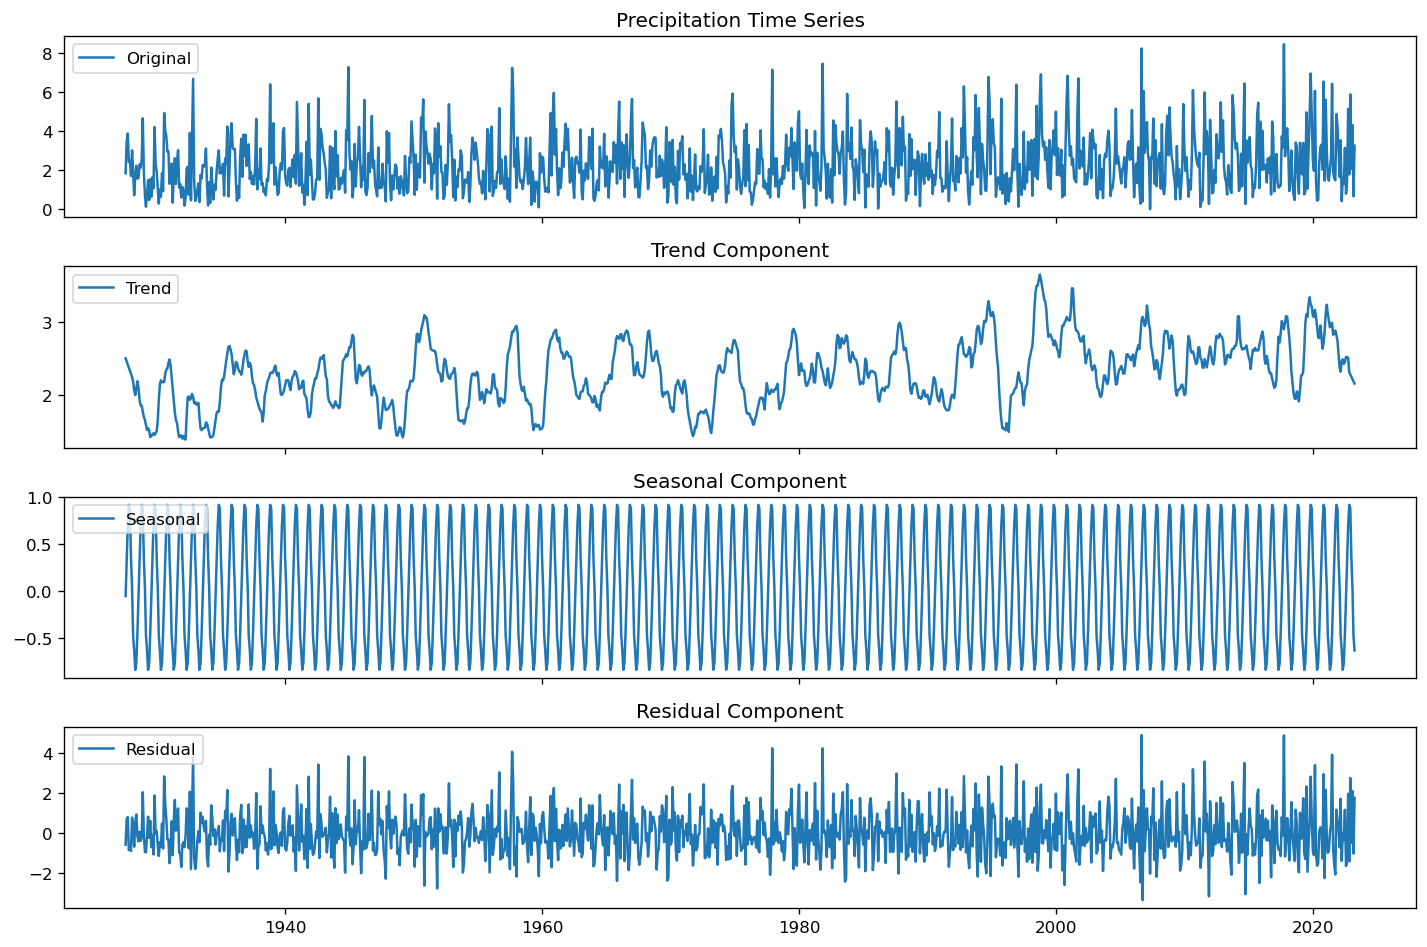

In [130]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
%matplotlib inline

df_seasson = df.resample('1M').mean()
df_seasson = df_seasson.sort_index()
decomposition = seasonal_decompose(df_seasson['precipitation'], model='additive', extrapolate_trend='freq')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Plot the original time series
ax1.plot(df_seasson['precipitation'], label='Original')
ax1.legend(loc='upper left')
ax1.set_title('Precipitation Time Series')

# Plot the trend component
ax2.plot(decomposition.trend, label='Trend')
ax2.legend(loc='upper left')
ax2.set_title('Trend Component')

# Plot the seasonal component
ax3.plot(decomposition.seasonal, label='Seasonal')
ax3.legend(loc='upper left')
ax3.set_title('Seasonal Component')

# Plot the residual component
ax4.plot(decomposition.resid, label='Residual')
ax4.legend(loc='upper left')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()


# LSTM

In [131]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    return df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]

# Hyper parameters
hyper_parameters = {
    'freq' : ['1d','5d', '7d', '14d', '1M', '1y'],
    'look_back' : [365, 73, 57, 26, 12, 10],
    'units' : [365, 73, 57, 26, 12, 10],
    'dropout_rate' : 0.2,
    'optimizer' : Adam(learning_rate=0.001)
}
stage = 4

def get_scaled_data(df, hyper_parameters, stage):
    # get dataset
    df_seasson = df.resample(hyper_parameters['freq'][stage]).mean()
    
    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_seasson)
    return scaled_data


def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def create_cnn(hyper_parameters):
    units = hyper_parameters['units'][stage]
    look_back = hyper_parameters['look_back'][stage]
    optimizer = hyper_parameters['optimizer']
    dropout_rate = hyper_parameters['dropout_rate']
    
    print("Hyper-parameters:")
    print(f"\tfreq: { hyper_parameters['freq'][stage]}")
    print(f"\tunits: {units}")
    print(f"\tlook_back: {look_back}")
    print(f"\tdropout_rate: {dropout_rate}")
    
          
    
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Get Dataset
scaled_data = get_scaled_data(df, hyper_parameters, stage)

look_back = hyper_parameters['look_back'][stage]

# Split dataset for test and training and create sequences.
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Create training and test sequences
train_X, train_y = create_sequences(train_data, look_back)
test_X, test_y = create_sequences(test_data, look_back)

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

# Create CNN model
model = create_cnn(hyper_parameters)

# Configure early stop
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
model.fit(train_X, train_y, epochs=100, batch_size=5, verbose=1, validation_split=0.2, callbacks=[early_stopping])


predictions = model.predict(test_X)
rmse = np.sqrt(mean_squared_error(test_y, predictions.flatten()))
print(f"RMSE: {rmse}")

2023-04-03 23:06:18.986208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 23:06:29.393161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-04-03 23:06:29.393289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not

Hyper-parameters:
	freq: 1M
	units: 12
	look_back: 12
	dropout_rate: 0.2
Epoch 1/100
145/145 [==============================] - 7s 17ms/step - loss: 0.0301 - val_loss: 0.0307
Epoch 2/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0252 - val_loss: 0.0322
Epoch 3/100
145/145 [==============================] - 1s 9ms/step - loss: 0.0249 - val_loss: 0.0322
Epoch 4/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0249 - val_loss: 0.0318
Epoch 5/100
145/145 [==============================] - 1s 9ms/step - loss: 0.0245 - val_loss: 0.0320
Epoch 6/100
145/145 [==============================] - 1s 9ms/step - loss: 0.0241 - val_loss: 0.0327
Epoch 7/100
145/145 [==============================] - 1s 9ms/step - loss: 0.0246 - val_loss: 0.0315
Epoch 8/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0243 - val_loss: 0.0326
Epoch 9/100
145/145 [==============================] - 1s 9ms/step - loss: 0.0236 - val_loss: 0.0300
Epoch 10/100
1

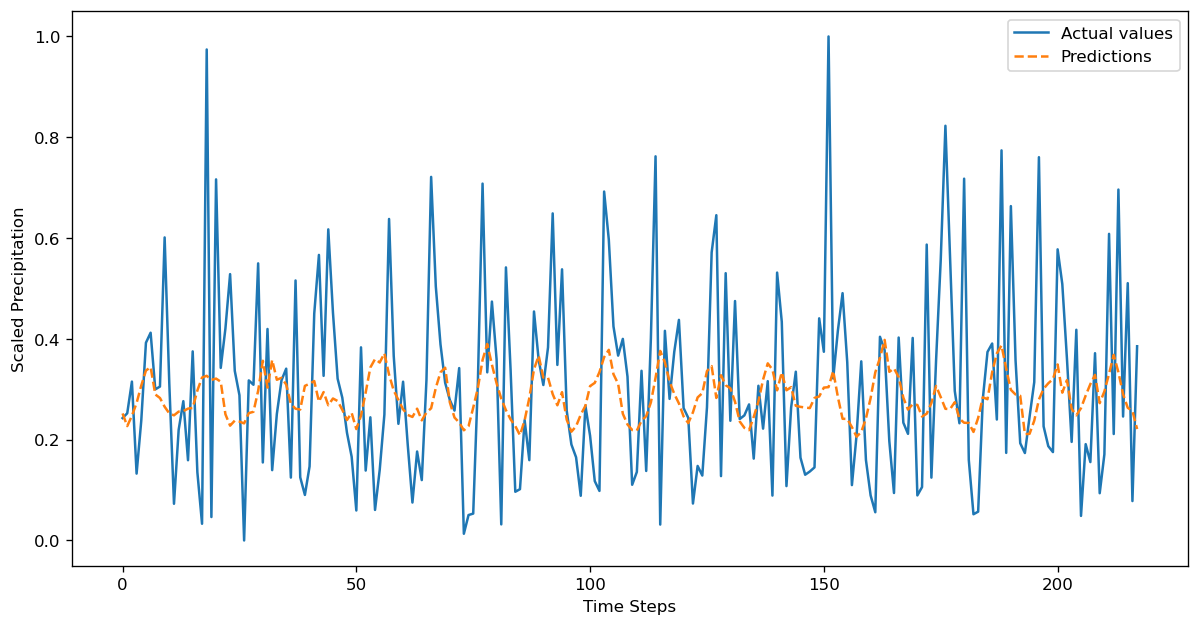

In [133]:
plt.figure(figsize=(12, 6))
plt.plot(test_y, label='Actual values')
plt.plot(predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()
